In [1]:
import os
import warnings
import sys
import matplotlib as plt

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
import seaborn as sns
import logging


In [2]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


In [3]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [4]:
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(40)

    # Read the wine-quality csv file from the URL
    csv_url = (
        "wine_data.csv"
    )
    try:
        data = pd.read_csv(csv_url, sep=",")
    except Exception as e:
        logger.exception(
            "Unable to download training & test CSV, check your internet connection. Error: %s", e
        )

<AxesSubplot:>

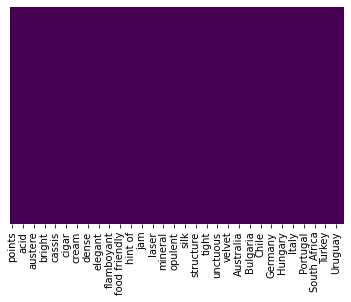

In [5]:
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120916 entries, 0 to 120915
Data columns (total 62 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   points         120916 non-null  float64
 1   price          120916 non-null  float64
 2   acid           120916 non-null  int64  
 3   angular        120916 non-null  int64  
 4   austere        120916 non-null  int64  
 5   barnyard       120916 non-null  int64  
 6   bright         120916 non-null  int64  
 7   butter         120916 non-null  int64  
 8   cassis         120916 non-null  int64  
 9   charcoal       120916 non-null  int64  
 10  cigar          120916 non-null  int64  
 11  complex        120916 non-null  int64  
 12  cream          120916 non-null  int64  
 13  crisp          120916 non-null  int64  
 14  dense          120916 non-null  int64  
 15  earth          120916 non-null  int64  
 16  elegant        120916 non-null  int64  
 17  flabby         120916 non-nul

In [ ]:
#data = dataset.sample(frac = 0.9, random_state=42)
#data_unseen =datasetdrop(data.index)
#data.reset_index(drop=True, inplace=True)
#data_unseen.reset_index(drop=True, inplace=True)

#from pycaret.classification import * # from pycaret.regression import *
#exp1 = (data=data,target='points', session_id=1)
#best = compare_models()
#svm = create_model('svm')
#svm #parametry modelu
#et =create_model('et')
#et_tuned =tune_model(et)
#svm_tuned =tune_model(svm)
#plot_model(et_tuned)
#evaluate_model(et_tuned)
#plot_model(et_tuned,plot='features')
# fonal = finalize_model(et_tuned)
#predict = predict_model(final,data=data_unseen)
#predict
#save_model(final,'nazwa')

In [23]:
corrmat = data.corr()
top_corr_features = corrmat.index
#plt.figure.Figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=False,cmap="RdYlGn") 
#plot_corr_matrix=g.get_figure()
#plot_corr_matrix.savefig("corr_matrix.png")


In [6]:
# #used only once to import the data 
# import glob

# extension = 'csv'
# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
# #combine all files in the list
# combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
# #export to csv
# combined_csv.to_csv( "wine_data.csv", index=False, encoding='utf-8-sig')

print(len(data))


rest,validate = train_test_split(data,test_size=0.2)
train, test = train_test_split(rest, test_size = 0.2)

# The predicted column is "quality" which is a scalar from [3, 9]


120916
77385
77385


In [ ]:
train_x = train.drop(["points"], axis=1)
test_x = test.drop(["points"], axis=1)
train_y = train[["points"]]
test_y = test[["points"]]

print(len(train_x))
unique_entries = train_x.duplicated(keep='first')

print(len(unique_entries))


# print(sys.argv[0])
# print(sys.argv[1])
# print(sys.argv[2])
alpha = 0.4
l1_ratio = 0.7

In [7]:
with mlflow.start_run():
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(train_x, train_y)

        predicted_qualities = lr.predict(test_x)

        (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

        print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
        print("  RMSE: %s" % rmse)
        print("  MAE: %s" % mae)
        print("  R2: %s" % r2)

        mlflow.log_param("alpha", alpha)
        mlflow.log_param("l1_ratio", l1_ratio)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":

            # Register the model
            # There are other ways to use the Model Registry, which depends on the use case,
            # please refer to the doc for more information:
            # https://mlflow.org/docs/latest/model-registry.html#api-workflow
            mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticnetWineModel")
        else:
            mlflow.sklearn.log_model(lr, "model")

Elasticnet model (alpha=0.400000, l1_ratio=0.700000):
  RMSE: 2.769968289941445
  MAE: 2.1599006456086878
  R2: 0.15428040259015907
